#Flopy3 Creating Layered Quadtree Grids with GRIDGEN

Flopy3 has a module that can be used to drive the GRIDGEN program.  This notebook shows how it works.

The Flopy GRIDGEN module requires that the gridgen executable can be called using subprocess.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridgen import Gridgen

GRIDGEN works off of a base MODFLOW grid.  The following information defines the basegrid.

In [2]:
Lx = 100.
Ly = 100.
nlay = 2
nrow = 51
ncol = 51
delr = Lx / ncol
delc = Ly / nrow
h0 = 10
h1 = 5
top = h0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[1, :, :] = -10.

In [3]:
m = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(m, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm, rotation=20.)

In [4]:
model_ws = os.path.join('.', 'data')
g = Gridgen(dis, model_ws=model_ws)
# g.add_active_domain('model_domain', [0])

In [5]:
# setup the active domain
adshp = os.path.join(model_ws, 'ad0')
adpoly = [[[(0, 0), (0, 60), (40, 80), (60, 0), (0, 0)]]]
# g.add_active_domain(adpoly, range(nlay))

In [6]:
x = Lx * np.random.random(10)
y = Ly * np.random.random(10)
wells = zip(x, y)
g.add_refinement_features(wells, 'point', 3, range(nlay))

In [7]:
river = [[[(-20, 10), (60, 60)]]]
g.add_refinement_features(river, 'line', 3, range(nlay))

In [8]:
g.add_refinement_features(adpoly, 'polygon', 1, range(nlay))

In [9]:
g.build()

Error.  Failed to export shared vertex vtk file []


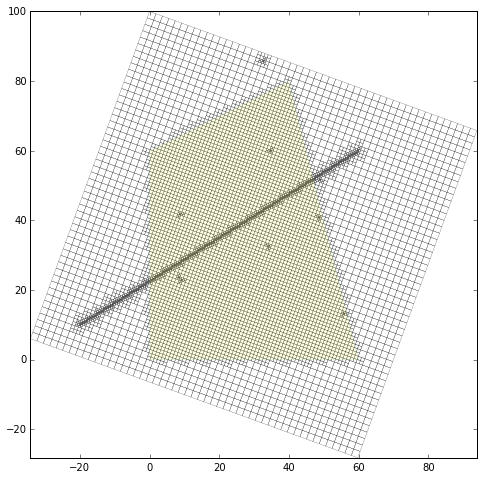

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.1)
flopy.plot.plot_shapefile(adshp, ax=ax, facecolor='yellow', alpha=0.1)